In [2]:
import scanpy as sc
import anndata as ad
import scvi
import pandas as pd
import numpy as np 
import omicverse as ov
from scipy.sparse import issparse

/home/kyh/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/kyh/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/kyh/miniconda3/envs/scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/kyh/miniconda3/envs/scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Pl

In [3]:
def table(my_list):
    return(pd.DataFrame(my_list).value_counts())
def str_which(strings,pattern):
    matches = []
    for i, string in enumerate(strings):
        if re.search(pattern, string):
            matches.append(i)
    return matches
def is_in(list1,list2):
    list = []
    for i in list1:
        if i in list2:
            list.append(True)
        else:
            list.append(False)
    return(list)

# Pre-train scVI model

In [59]:
islet = sc.read_h5ad('h5ad/islet_all.h5ad')

In [60]:
sample3 = is_in(islet.obs['author'],'Camunas-Soler et al.')
islet = islet[np.invert(sample3)].copy()

In [62]:
def change_cell_type(x):
    if x == 'beta':
        x = 'Beta'
    elif x == 'alpha':
        x = 'Alpha'
    elif x == 'immune':
        x = 'Immune'
    elif x == 'endothelial':
        x = 'Endothelial'
    elif x == 'delta':
        x = 'Delta'
    return(x)

In [63]:
new_celltype = [change_cell_type(i) for i in islet.obs.cell_type]
islet.obs['cell_type'] = new_celltype

In [67]:
pp_cell = is_in(islet.obs['cell_type'],'PP')
islet = islet[np.invert(pp_cell)].copy()

In [68]:
islet.obs['batch'] = islet.obs['donor']
islet.layers['counts'] = islet.X.copy()

In [69]:
islet.raw = islet

In [70]:
sc.pp.highly_variable_genes(
    islet,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="author",
    subset=True,
)

In [ ]:
islet.write_h5ad('h5ad/human_islet_400k_raw.h5ad',compression='gzip')
#Pre-train with scVI
#~/miniconda3/envs/scvi/bin/python train_ref_scVI.py human_islet_400k_processed.h5ad
#Run in HPC

# Load Pre-trained models

In [4]:
islet = sc.read_h5ad('h5ad/human_islet_400k_raw.h5ad')

In [22]:
islet_scVI_model = scvi.model.SCVI.load( dir_path = './human_islet_400k_raw_scVI_model/',adata = islet)
islet_scVI_model.is_trained

INFO     File ./human_islet_400k_raw_scVI_model/model.pt already downloaded                                        


True

In [23]:
islet_scANVI_model = scvi.model.SCANVI.load(dir_path = './human_islet_400k_raw_scANVI_model/',adata=islet )
islet_scANVI_model.is_trained

INFO     File ./human_islet_400k_raw_scANVI_model/model.pt already downloaded                                      


True

In [24]:
islet.obsm['X_scVI'] = islet_scVI_model.get_latent_representation()
islet.obsm['X_scANVI'] = islet_scVI_model.get_latent_representation()

In [26]:
islet.obsm['X_scVI_mde'] = scvi.model.utils.mde(islet.obsm['X_scVI'])

Nov 10 03:03:32 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Nov 10 03:03:32 PM: The following items have duplicates [19275 19276 19278 ... 95571 95572 95573]


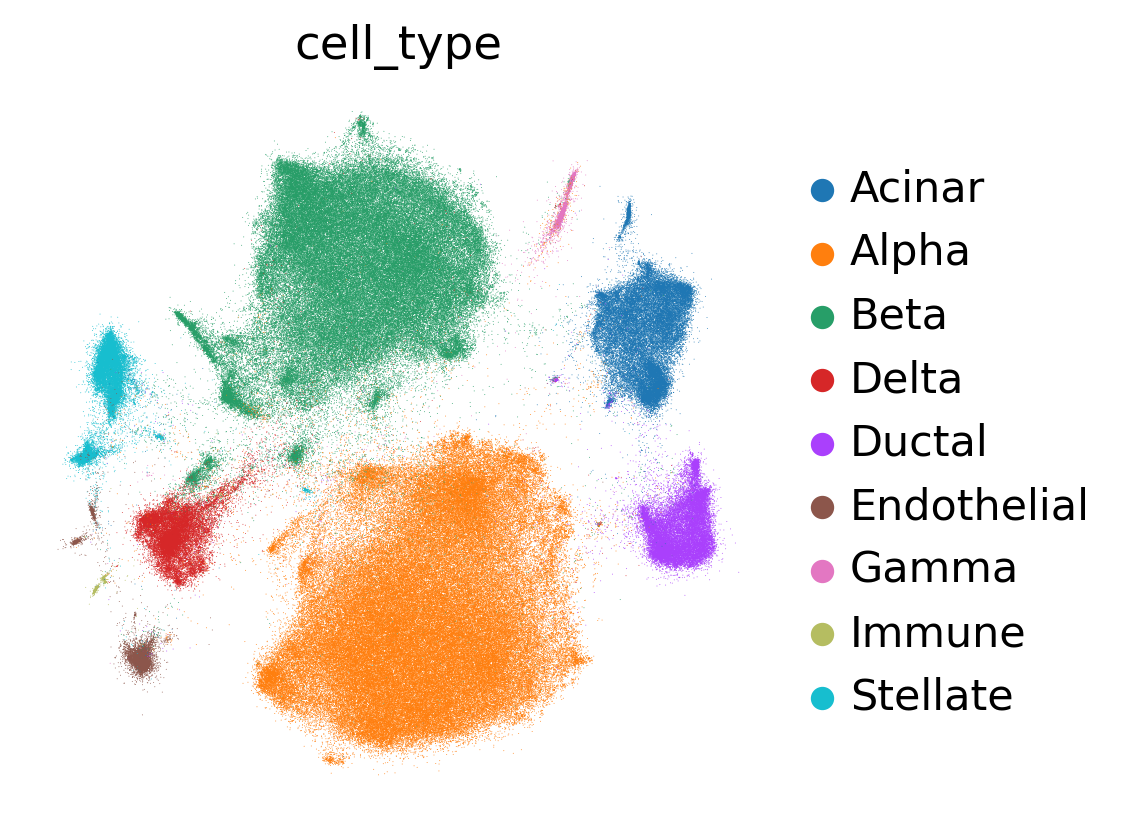

In [27]:
sc.pl.embedding(islet, basis='X_scVI_mde', color=["cell_type"], frameon=False, ncols=1)

In [28]:
islet.obsm['X_scANVI_mde'] = scvi.model.utils.mde(islet.obsm['X_scANVI'])

Nov 10 03:16:40 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Nov 10 03:16:40 PM: The following items have duplicates [19275 19276 19278 ... 95572 95573 95574]


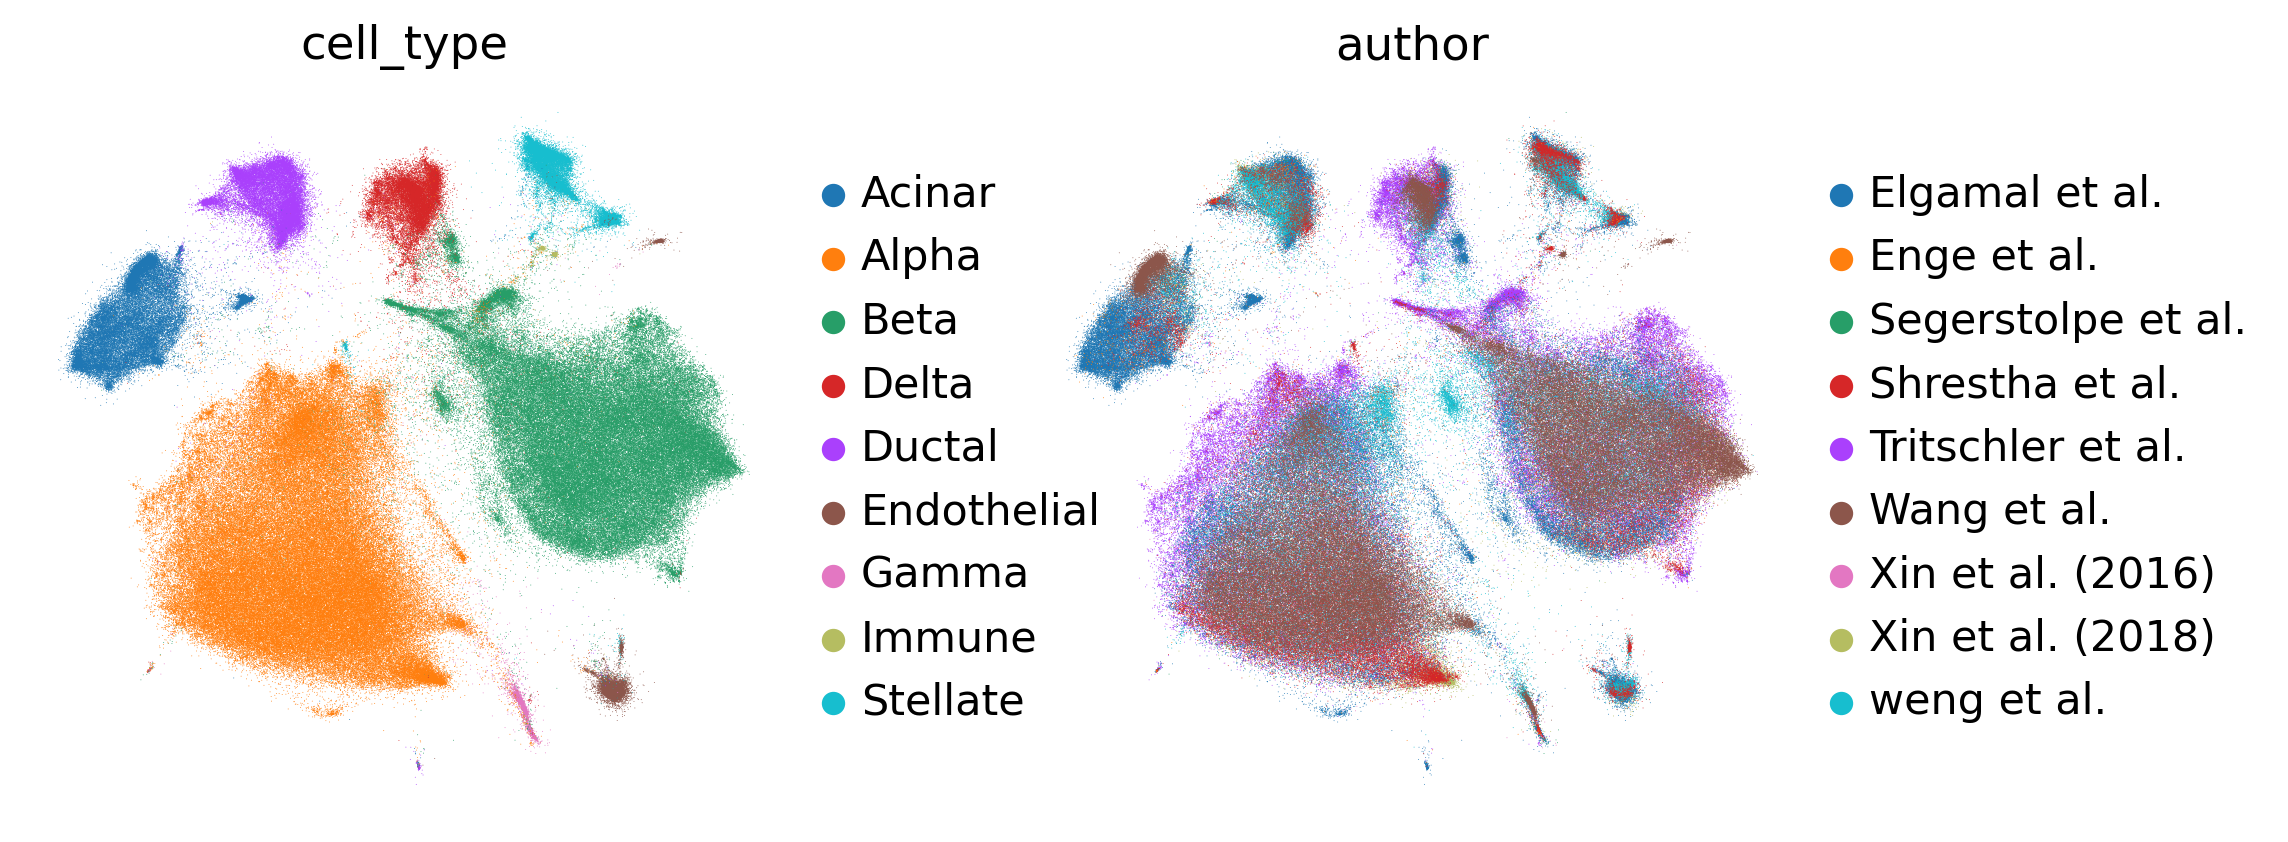

In [37]:
sc.pl.embedding(islet, basis='X_scANVI_mde', color=["cell_type",'author'], frameon=False, ncols=2)

In [31]:
islet.write('./h5ad/human_islet_400k_processed.h5ad',compression='gzip')